# **Image Captioning using ResNet-152 and LSTM**

## **Part 3: Evaluating Model Performance**

To ensure the model generates high-quality test_test_test_captions, several evaluation metrics are employed to compare generated captions against ground truth descriptions.

### Steps:

1. **Compute BLEU Scores**: The **Bilingual Evaluation Understudy (BLEU) score** assesses the overlap of n-grams between generated and reference captions.
2. **Use METEOR and ROUGE Metrics**: These alternative metrics provide additional insights into the quality and fluency of generated captions.
3. **Human Evaluation**: Subjective assessment by human annotators ensures the captions are meaningful and contextually appropriate.
4. **Check Diversity and Generalization**: The model's ability to generate diverse captions for different images is analyzed.
5. **Test on Unseen Images**: The model is tested on images outside the training set to assess its robustness and generalization capabilities.

These evaluation techniques help refine the model and ensure its practical usability in real-world applications.



---

In [ ]:
import sys
sys.path.insert(0,'../')

import pickle
from tqdm import tqdm

from Pipeline.data_retrieving.Image_Caption_data_retriever import Image_Caption_data_retriever
from Pipeline.modelling.dataloader.Image_Local_Dataloader import Image_Local_DataLoader

from Pipeline.modelling.models.DecoderLSTM import *
from Pipeline.modelling.models.EncoderCNN import *

### Load the EncoderCNN and the pretrained DecoderLSTM

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# use the same tokenizer used in the encoder
with open("data/custom_tokenizer.pkl", "rb") as file:
    # Load the serialized list
    tokenizer = pickle.load(file)
    
# Initialize the model structure first
decoderLSTM = DecoderLSTM(
    vocab_size=tokenizer.my_vocabulary.__len__(),
    tokenizer=tokenizer
)

decoderLSTM.load_state_dict(torch.load("data/trained_decoder.pt", map_location=device, weights_only=True))
decoderLSTM.to(device)
decoderLSTM.eval()

In [ ]:
encoderCNN = EncoderCNN()
encoderCNN.to(device)

### Load the test set captions

In [5]:
# load the captions and the image IDs
test_data_retriever = Image_Caption_data_retriever()

test_data_retriever.retrieve_data('./data/flickr8k-custom/captions/Flickr8k_test.token.txt')

# print the head
display(test_data_retriever.get_data().head())

print(f"there are {len(test_data_retriever.get_data())} testing examples in the training set")

test_captions = test_data_retriever.get_data()['caption']

# prepare the list of images ot load
list_of_images = test_data_retriever.get_data()['image_ID'][::5]  # take every 5th image, because they are repeted 5 times
list_of_images = list_of_images.map(lambda image_ID: './data/Flicker8k_Dataset/' + image_ID)
list_of_images = list_of_images.to_list()

,image_ID,caption
0,377872472_35805fc143.jpg,One dog is standing whilst two other dogs are ...
1,377872472_35805fc143.jpg,Three dogs are playing around in the snow .
2,377872472_35805fc143.jpg,Three dogs chasing each other in the snow .
3,377872472_35805fc143.jpg,Three dogs play in snow .
4,377872472_35805fc143.jpg,Two dogs play together in the snow .


there are 5015 testing examples in the training set


In [6]:
# apply the same preprocessing on the captions as we did on the training set
from nltk.tokenize import RegexpTokenizer
import re

# Apply lowercase
test_captions = test_captions.map(lambda s: str.lower(s.strip()))  # Strip leading/trailing spaces

# Remove numbers, special characters, and punctuation
test_captions = test_captions.map(lambda caption: re.sub(r'[^a-zA-Z\s]+', '', caption))  
test_captions = test_captions.map(lambda caption: re.sub(r'\s+', ' ', caption).strip())  # Normalize spaces

# now tokenize each caption
# create tokenizer
tk = RegexpTokenizer(r'\w+')
test_captions = test_captions.map(lambda caption: tk.tokenize(caption))

test_captions = test_captions.to_list()

### Create a dataloader for the test set images

In [7]:
from torchvision import transforms

# Preprocessing to be apply to the images to be fed to the resnet (reference PyTorch doc)
resenet_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# NOTE: the IDs inside the list are repeated 5 time, because for each image there are 5 captions. 
# Instead of computing the same feature 5 times, I will do it only once and then re-copy the result 5 times
image_dataloader = Image_Local_DataLoader(
    x=list_of_images,
    batch_size=1,
    shuffle=False,
    image_preprocessing_fn = resenet_transform
)

In [9]:
# create empty tensor to put the features inside
N_samples = image_dataloader.__len__()
feature_lenght = 2048  # I know that the output will be of lenght 2048 because I inspected the architecture of the model and verified this value
features = torch.empty((N_samples,feature_lenght), device=device)

### Encoder the test images using the same encoder used before

In [10]:
# iterate over the whole dataset
start_idx = 0

for inputs in tqdm(image_dataloader):
    # convert from tf to torch
    inputs = torch.tensor(inputs.numpy(), dtype=torch.float32)
    
    inputs = inputs.to(device)
    batch_size = inputs.shape[0]
    
    # run the encoding 
    feature = encoderCNN(inputs)
    
    # Store features in the tensor
    features[start_idx : (start_idx + batch_size)] = feature

    # Update index
    start_idx += batch_size
    

100%|██████████| 1003/1003 [00:20<00:00, 47.81it/s]


---

### Now pass the encoded images through the Decoder to generate the captions

In [11]:
predicted_captions = []
for f in tqdm(features):
    # predict the caption
    caption = decoderLSTM.sample(f.unsqueeze(0))
    
    # decode the prediction using the same tokeizer as before
    caption = tokenizer.decode(caption.squeeze(0))
    
    # split the caption to match the format of ground truth captions
    caption = caption.split(' ')
    
    # append the caption
    predicted_captions.append(caption)

100%|██████████| 1003/1003 [00:04<00:00, 211.70it/s]


---

### Compute BLEU, METEOR, ROUGE and CIDEr scores

In [12]:
from pycocoevalcap.eval import COCOEvalCap
from pycocotools.coco import COCO
import json

In [13]:
def convert_to_coco_format(ground_truth, prediction, captions_per_image):
    """
    Converts lists of ground truth captions (tokenized) and predicted captions (tokenized)
    into the COCO JSON format required for evaluation.

    Parameters:
      ground_truth (list of lists): Each inner list is a tokenized caption.
                                    Captions are assumed to be ordered such that
                                    every group of `captions_per_image` belongs to one image.
      prediction (list of lists): Each inner list is a tokenized predicted caption.
                                  One prediction per image.
      captions_per_image (int): Number of ground truth captions per image.

    Returns:
      coco_gt (dict): Dictionary in COCO format for ground truths.
      coco_preds (list): List of dictionaries in COCO format for predictions.
    """
    # Number of images can be derived from predictions (or ground_truth length divided by captions_per_image)
    num_images = len(prediction)
    
    # Build the "images" list (each image needs a unique id and optionally a filename)
    images = [{"id": i, "file_name": f"{i}.jpg"} for i in range(num_images)]
    
    # Build the "annotations" list for ground truth captions.
    annotations = []
    for i in range(num_images):
        for j in range(captions_per_image):
            # Compute the index in ground_truth list for this caption.
            gt_index = i * captions_per_image + j
            # Join tokens into a string.
            caption_str = ' '.join(ground_truth[gt_index])
            annotations.append({
                "image_id": i,
                "id": gt_index,  # Unique ID for each caption.
                "caption": caption_str
            })
    
    coco_gt = {
        "images": images,
        "annotations": annotations
    }
    
    # Build predictions in COCO format.
    coco_preds = []
    for i in range(num_images):
        # Join tokens into a string.
        caption_str = ' '.join(prediction[i])
        coco_preds.append({
            "image_id": i,
            "caption": caption_str
        })
    
    return coco_gt, coco_preds

In [14]:
coco_gts, coco_preds = convert_to_coco_format(test_captions, predicted_captions, captions_per_image=5)

In [ ]:
with open("data/gts.json", "w") as f:
    json.dump(coco_gts, f)
with open("data/preds.json", "w") as f:
    json.dump(coco_preds, f)

# Load and evaluate
coco = COCO("data/gts.json")  
coco_results = coco.loadRes("data/preds.json")

coco_eval = COCOEvalCap(coco, coco_results)

coco_eval.evaluate()

In [16]:
for metric, score in coco_eval.eval.items():
    print(f"{metric}: {score:.3f}")

Bleu_1: 0.484
Bleu_2: 0.291
Bleu_3: 0.170
Bleu_4: 0.098
METEOR: 0.160
ROUGE_L: 0.369
CIDEr: 0.247
SPICE: 0.105


---

### show some examples of the predicted captions

In [17]:
import matplotlib.pyplot as plt
import random

In [33]:
# sample two indeces
indeces = [992, 57]

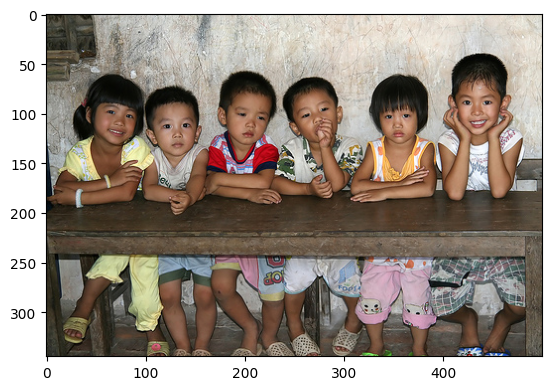

a group of children sitting on a bench




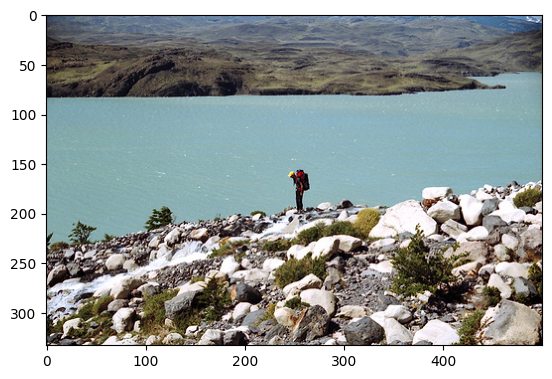

a hiker is climbing a rocky cliff overlooking a deep blue lake




In [34]:
for index in indeces:
    filename = './data/Flicker8k_Dataset/' + test_data_retriever.get_data()['image_ID'][::5].iloc[index]

    # plot the image
    plt.figure()
    image = plt.imread(filename)
    plt.imshow(image)
    plt.show()

    # print the caption
    caption = decoderLSTM.sample(features[index].to(device).unsqueeze(0))
    decoded = tokenizer.decode(caption.squeeze(0))

    print(decoded)
    print()
    print()